# Diffusivity tensor for any resolution

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [2]:
Lcoarse = 50e3

In [3]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

In [4]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km.nc')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')

In [5]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [6]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [7]:
[UdagCdag, VdagCdag, WdagCdag] = get_stationary_flux_arrays(Trac_coarse, Vels_coarse, list_trac)

In [24]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_fast = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(1,19,2)),
                       VpCp.sel(tracer_num=slice(1,19,2)),
                       WpCp.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_fast.load() # need to load because we will take transpose and a

CPU times: user 11.6 s, sys: 25.1 ms, total: 11.6 s
Wall time: 11.6 s


In [23]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_stat_fast = xr.apply_ufunc(calc_tensor, 
                       UdagCdag.sel(tracer_num=slice(1,19,2)),
                       UdagCdag.sel(tracer_num=slice(1,19,2)),
                       UdagCdag.sel(tracer_num=slice(1,19,2)),
                       dCdx.sel(tracer_num=slice(1,19,2)),
                       dCdy.sel(tracer_num=slice(1,19,2)),
                       dCdz.sel(tracer_num=slice(1,19,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_stat_fast.load() # need to load because we will take transpose and a

CPU times: user 11.9 s, sys: 25.5 ms, total: 11.9 s
Wall time: 12 s


In [25]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_slow = xr.apply_ufunc(calc_tensor, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_slow.load() # need to load because we will take transpose and a

CPU times: user 11.4 s, sys: 16.4 ms, total: 11.4 s
Wall time: 11.4 s


In [26]:
%%time
# Calculate the tensor
# This is slow (can take over an hour)

Ktensor_stat_slow = xr.apply_ufunc(calc_tensor, 
                       UdagCdag.sel(tracer_num=slice(2,20,2)),
                       VdagCdag.sel(tracer_num=slice(2,20,2)),
                       WdagCdag.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num'], ['tracer_num']],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

Ktensor_stat_slow.load() # need to load because we will take transpose and a

CPU times: user 11.3 s, sys: 23.4 ms, total: 11.3 s
Wall time: 11.3 s


In [1]:
31104000*6

186624000

In [28]:
lam1 = 1/31104000.
lam2 = 1/186624000.

Ktensor_corr = (lam2*Ktensor_fast - lam1*Ktensor_slow)/(lam2 - lam1)
Ktensor_stat_corr = (lam2*Ktensor_stat_fast - lam1*Ktensor_stat_slow)/(lam2 - lam1)

In [29]:
Ktensor_corrT = Ktensor_corr.transpose('Z','YCcoarse','XCcoarse','j','i')

STcorr = 0.5*(Ktensor_corr.data + Ktensor_corrT.data)
ATcorr = 0.5*(Ktensor_corr.data - Ktensor_corrT.data)

STcorr= xr.DataArray(STcorr, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)
ATcorr = xr.DataArray(ATcorr, coords=Ktensor_corr.coords, dims=Ktensor_corr.dims)

In [30]:
Ktensor_stat_corrT = Ktensor_stat_corr.transpose('Z','YCcoarse','XCcoarse','j','i')

ST_stat_corr = 0.5*(Ktensor_stat_corr.data + Ktensor_stat_corrT.data)
AT_stat_corr = 0.5*(Ktensor_stat_corr.data - Ktensor_stat_corrT.data)

ST_stat_corr = xr.DataArray(ST_stat_corr, coords=Ktensor_stat_corr.coords, dims=Ktensor_stat_corr.dims)
AT_stat_corr = xr.DataArray(AT_stat_corr, coords=Ktensor_stat_corr.coords, dims=Ktensor_stat_corr.dims)

In [31]:
Ktensor_slowT = Ktensor_slow.transpose('Z','YCcoarse','XCcoarse','j','i')

STslow = 0.5*(Ktensor_slow.data + Ktensor_slowT.data)
ATslow = 0.5*(Ktensor_slow.data - Ktensor_slowT.data)

STslow = xr.DataArray(STslow, coords=Ktensor_slow.coords, dims=Ktensor_slow.dims)
ATslow = xr.DataArray(ATslow, coords=Ktensor_slow.coords, dims=Ktensor_slow.dims)

In [32]:
Ktensor_fastT = Ktensor_fast.transpose('Z','YCcoarse','XCcoarse','j','i')

STfast = 0.5*(Ktensor_fast.data + Ktensor_fastT.data)
ATfast = 0.5*(Ktensor_fast.data - Ktensor_fastT.data)

STfast = xr.DataArray(STfast, coords=Ktensor_fast.coords, dims=Ktensor_fast.dims)
ATfast = xr.DataArray(ATfast, coords=Ktensor_fast.coords, dims=Ktensor_fast.dims)

In [33]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    eigenValues, eigenVectors = eigh(A)
    idx = np.argsort(np.abs(eigenValues))
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors)

## Rotation of EVs

(800000.0, 1200000.0)

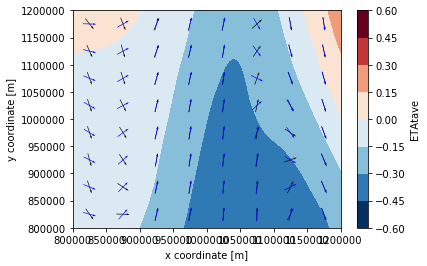

In [220]:
X = Vels_coarse.XCcoarse
Y = Vels_coarse.YCcoarse
speed = (Vels_coarse.U**2 + Vels_coarse.V**2)**0.5
U = (Vels_coarse.U/speed)
V = (Vels_coarse.V/speed)

Model_Tav.ETAtave.plot.contourf(levels=10)
plt.quiver(X, Y, U.sel(Z=-1000, method='nearest'), V.sel(Z=-1000, method='nearest'), scale=20,pivot='mid')
plt.quiver(X, Y, U.sel(Z=-500, method='nearest'), V.sel(Z=-500, method='nearest'), scale=20,pivot='mid', color='b')

plt.xlim([800e3,1200e3])
plt.ylim([800e3, 1200e3])

In [319]:
zloc = -300
xloc = 1000e3 
yloc = 980e3

M = STcorr.sel(Z=zloc, XCcoarse=xloc, YCcoarse=yloc, method='nearest')

In [320]:
eigenValues, eigenVectors = eigh(M)

In [321]:
U = Vels_coarse.U.sel(Z=zloc, XCcoarse=xloc, YCcoarse=yloc, method='nearest').values
V = Vels_coarse.V.sel(Z=zloc, XCcoarse=xloc, YCcoarse=yloc, method='nearest').values

In [322]:
flow = np.array([U, V, 0])
flow

array([0.01187609, 0.06926139, 0.        ])

In [323]:
eigenVectors

array([[ 0.423023  ,  0.01256889,  0.9060317 ],
       [-0.90577036, -0.02187161,  0.42320442],
       [-0.02513558,  0.9996818 , -0.00213233]], dtype=float32)

In [324]:
dotp = np.abs(np.matmul(flow, eigenVectors ))
dotp

array([0.05771105, 0.00136559, 0.04007184])

In [331]:
id1 = np.where(np.abs(dotp) == max(np.abs(dotp)))
id1[0][0]

0

In [332]:
id3 = np.where(np.abs(eigenVectors[2,:]) == max(np.abs(eigenVectors[2,:])))
id3[0][0]

1

In [327]:
temp

[0, 1, 2]

In [328]:
np.logical_and(temp!=id1[0][0] , temp!=id3[0][0])

array([False, False,  True])

In [333]:
temp = [0,1,2]
id2 = np.where(np.logical_and(temp!=id1[0][0] , temp!=id3[0][0]))
id2[0][0]

2

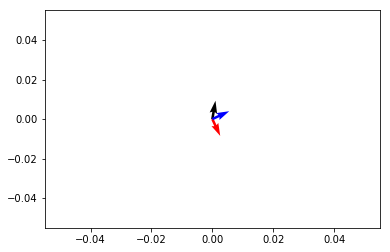

In [334]:
plt.quiver(U,V)
plt.quiver(eigenVectors[0,id1], eigenVectors[1,id1], color='r')
plt.quiver(eigenVectors[0,id2], eigenVectors[1,id2], color='b')

In [335]:
# An alternate way to sort eigenvalues is to say 
# 3 = ev that evec with largest value in Z direction
# 1 = ev that that has even that larger projection with the horizontal mean flow (u,v,0)
# 2 = remaing ev; the one that is quasi-perpendicular to the mean flow. 

def eigen_align_flow(A, u ,v):
    eigenValues, eigenVectors = eigh(A)
    #print(eigenValues)
    eigvalsorted = np.zeros_like(eigenValues)
    eigvecsorted = np.zeros_like(eigenVectors)
    
    flowvec = np.array([u, v, 0])
    dotp = np.abs(np.matmul(flowvec, eigenVectors ))
    
    id1 = np.where(np.abs(dotp) == max(np.abs(dotp)))
    eigvalsorted[0] = eigenValues[id1[0][0]]
    eigvecsorted[:,0] = eigenVectors[:,id1[0][0]]
            
    id3 = np.where(np.abs(eigenVectors[2,:]) == max(np.abs(eigenVectors[2,:])))
    #print(id3)
    eigvalsorted[2] = eigenValues[id3[0][0]]
    eigvecsorted[:,2] = eigenVectors[:,id3[0][0]]
    
    #id2 = np.where(np.logical_and(np.abs(eigenVectors[2,:]) != max(np.abs(eigenVectors[2,:])), dotp != max(dotp)))
    temp = [0,1,2]
    id2 = np.where(np.logical_and(temp!=id1[0][0] , temp!=id3[0][0]))
    eigvalsorted[1] = eigenValues[id2[0][0]]
    eigvecsorted[:,1] = eigenVectors[:,id2[0][0]] 
    
    return (eigvalsorted, eigvecsorted)

In [336]:
eigvalsSTcorr_aligned, eigvecsSTcorr_aligned = xr.apply_ufunc(eigen_align_flow, STcorr, Vels_coarse.U, Vels_coarse.V, 
                                                              input_core_dims=[['i','j'],[],[]],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [337]:
eigenVectors = eigvecsSTcorr_aligned.sel(Z=zloc, XCcoarse=xloc, YCcoarse=yloc, method='nearest').values
eigenVectors

array([[ 0.423023  ,  0.9060317 ,  0.01256889],
       [-0.90577036,  0.42320442, -0.02187161],
       [-0.02513558, -0.00213233,  0.9996818 ]], dtype=float32)

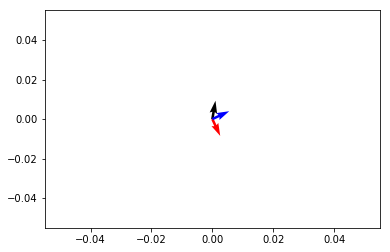

In [338]:
plt.quiver(U,V)
plt.quiver(eigenVectors[0,0], eigenVectors[1,0], color='r')
plt.quiver(eigenVectors[0,1], eigenVectors[1,1], color='b')

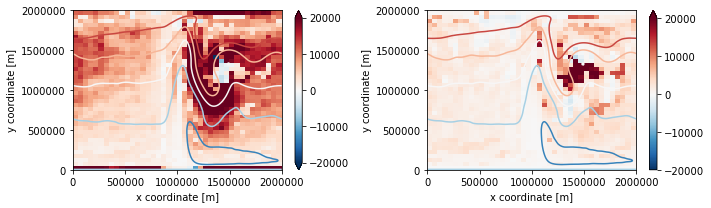

In [339]:
plt.figure(figsize=(10,3))

zloc= -500
plt.subplot(121)
eigvalsSTcorr_aligned.isel(ii=0).sel(Z=zloc, method='nearest').plot(vmax=2e4)
Model_Tav.ETAtave.plot.contour()

plt.subplot(122)
eigvalsSTcorr_aligned.isel(ii=1).sel(Z=zloc, method='nearest').plot(vmax=2e4)
Model_Tav.ETAtave.plot.contour()

plt.tight_layout()


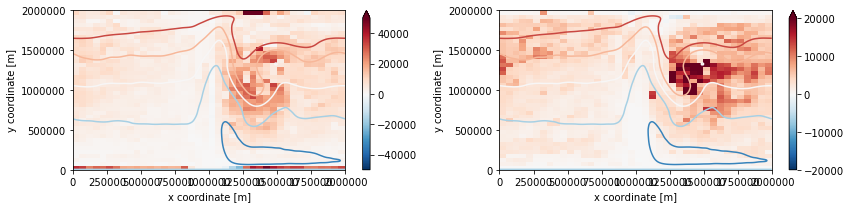

In [340]:
plt.figure(figsize=(12,3))

zloc= -1300
plt.subplot(121)
eigvalsSTcorr_aligned.isel(ii=0).sel(Z=zloc, method='nearest').plot(vmax=5e4)
Model_Tav.ETAtave.plot.contour()

plt.subplot(122)
eigvalsSTcorr_aligned.isel(ii=1).sel(Z=zloc, method='nearest').plot(vmax=2e4)
Model_Tav.ETAtave.plot.contour()

plt.tight_layout()


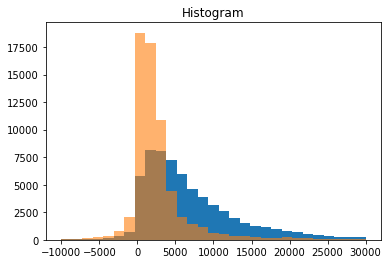

In [341]:
bins = np.linspace(-1e4, 3e4, 30)
[_,_,_]= eigvalsSTcorr_aligned.isel(ii=0).plot.hist(bins=bins)
[_,_,_]= eigvalsSTcorr_aligned.isel(ii=1).plot.hist(bins=bins, alpha=0.6)
#[_,_,_]= eigvalsSTcorr_aligned.isel(ii=2).plot.hist()


## End section of EV rotations. 

In [34]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsSTcorr, eigvecsSTcorr = xr.apply_ufunc(eigen, STcorr, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])
eigvalsST_stat_corr, eigvecsST_stat_corr = xr.apply_ufunc(eigen, ST_stat_corr, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])
eigvalsSTslow, eigvecsSTslow = xr.apply_ufunc(eigen, STslow, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])
eigvalsSTfast, eigvecsSTfast = xr.apply_ufunc(eigen, STfast, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

In [37]:
diff_tensor = xr.Dataset()
diff_tensor['Kfast'] = Ktensor_fast
diff_tensor['Kslow'] = Ktensor_slow
diff_tensor['Kcorr'] = Ktensor_corr
diff_tensor['K_stat_corr'] = Ktensor_stat_corr
diff_tensor['STcorr'] = STcorr
diff_tensor['ATcorr'] = ATcorr
diff_tensor['ST_stat_corr'] = ST_stat_corr
diff_tensor['AT_stat_corr'] = AT_stat_corr
diff_tensor['eigvalsSTcorr'] = np.real(eigvalsSTcorr)
diff_tensor['eigvecsSTcorr'] = eigvecsSTcorr
diff_tensor['eigvalsST_stat_corr'] = np.real(eigvalsST_stat_corr)
diff_tensor['eigvecsST_stat_corr'] = eigvecsST_stat_corr


#diff_tensor['eigvalsSTcorr_aligned'] = np.real(eigvalsSTcorr_aligned)
#diff_tensor['eigvecsSTcorr_aligned'] = eigvecsSTcorr_aligned

diff_tensor['STslow'] = STslow
diff_tensor['ATslow'] = ATslow
diff_tensor['eigvalsSTslow'] = np.real(eigvalsSTslow)
diff_tensor['eigvecsSTslow'] = eigvecsSTslow
diff_tensor['STfast'] = STfast
diff_tensor['ATfast'] = ATfast
diff_tensor['eigvalsSTfast'] = np.real(eigvalsSTfast)
diff_tensor['eigvecsSTfast'] = eigvecsSTfast

In [39]:
diff_tensor.to_netcdf('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km_stat.nc')

# Some maps to see if the fast or slow restoring has more negative eigenvalues

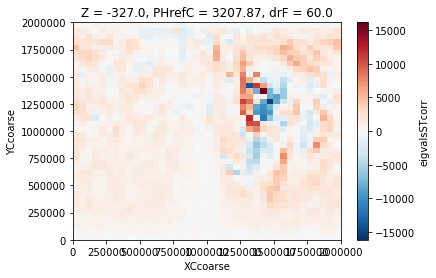

In [67]:
diff_tensor['eigvalsSTcorr'].isel(ii=1).sel(Z=-300, method='nearest').plot()

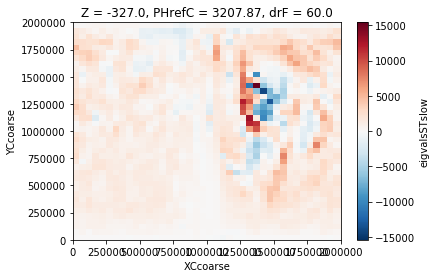

In [68]:
diff_tensor['eigvalsSTslow'].isel(ii=1).sel(Z=-300, method='nearest').plot()

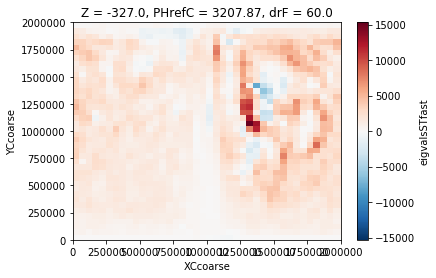

In [69]:
diff_tensor['eigvalsSTfast'].isel(ii=1).sel(Z=-300, method='nearest').plot()

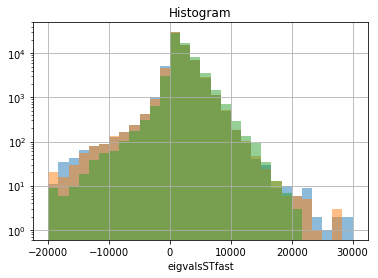

In [73]:
bins = np.linspace(-2e4,3e4,31)

[_,_,_]=diff_tensor['eigvalsSTcorr'].isel(ii=1).plot.hist(bins=bins, alpha=0.5)
[_,_,_]=diff_tensor['eigvalsSTslow'].isel(ii=1).plot.hist(bins=bins, alpha=0.5)
[_,_,_]=diff_tensor['eigvalsSTfast'].isel(ii=1).plot.hist(bins=bins, alpha=0.5)


plt.yscale('log')
plt.grid()